In [1]:
from methods.config import *
import numpy as np; rnd=np.random.default_rng()
import matplotlib.pyplot as plt; import matplotlib as mpl
import methods.util as util
import pickle
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats
from importlib import reload
#import permutations library
from itertools import permutations, combinations

In [2]:
pickled_dir = '/Users/daniel/Documents/GoodLab/btheta_barcoded_evolution/data/pickled'
save_dir = '/Users/daniel/Documents/GoodLab/btheta_barcoded_evolution/data/pickled'

with open(f'{pickled_dir}/barcodes.pkl', 'rb') as f:
    barcodes = pickle.load(f)

with open(f'{pickled_dir}/vivo_array.pkl', 'rb') as f:
    vivo_array = pickle.load(f)

with open(f'{pickled_dir}/vivo_depths.pkl', 'rb') as f:
    vivo_depths = pickle.load(f)

with open(f'{pickled_dir}/vitro_array.pkl', 'rb') as f:
    vitro_array = pickle.load(f)

with open(f'{pickled_dir}/vitro_depths.pkl', 'rb') as f:
    vitro_depths = pickle.load(f)

with open(f'{pickled_dir}/reseq_array.pkl', 'rb') as f:
    reseq_array = pickle.load(f)

with open(f'{pickled_dir}/reseq_depths.pkl', 'rb') as f:
    reseq_depths = pickle.load(f)

with open(f'{pickled_dir}/timecourse_meta.pkl', 'rb') as f:
    library_meta = pickle.load(f)

with open(f'{pickled_dir}/library_array_map.pkl', 'rb') as f:
    library_array_map = pickle.load(f)

with open(f'{pickled_dir}/medium_to_well_map.pkl', 'rb') as f:
    medium_to_well_map = pickle.load(f)

with open(f'{pickled_dir}/well_to_medium_map.pkl', 'rb') as f:
    well_to_medium_map = pickle.load(f)

with open(f'{pickled_dir}/col_id_map.pkl', 'rb') as f:
    col_id_map = pickle.load(f)

barcode_arrays = {'vivo': (vivo_array, vivo_depths),
                  'vitro': (vitro_array, vitro_depths),
                  'reseq': (reseq_array, reseq_depths)}

import methods.shared as shared

We can detect contamination (e.g. index hopping) across our two sequencing runs.

[(1e-07, 4.901513881577464e-07, 3.139037312863911e-06), (1e-07, 1e-07, 6.689778735888658e-07), (1e-07, 5.781362736573363e-07, 6.76967276361943e-06), (1e-07, 3.8481237895245606e-07, 1.549471775897466e-06), (1e-07, 1e-07, 4.85565312431282e-07), (1e-07, 3.816323407457783e-07, 4.2546220997235935e-05), (1e-07, 3.3303360309055185e-07, 4.0780900226098784e-05), (1e-07, 1e-07, 7.812167586595135e-07), (1e-07, 1e-07, 3.091610397202051e-07), (1e-07, 1e-07, 6.015174367188112e-07), (1e-07, 1e-07, 1.043513093657408e-07), (1e-07, 1e-07, 5.801448886777523e-07), (1e-07, 1e-07, 5.399535563036812e-07), (1e-07, 1e-07, 3.989333706905732e-07), (1e-07, 1e-07, 1e-07), (1e-07, 1e-07, 2.030599170371606e-07), (1e-07, 1e-07, 1.7247629661300804e-07), (1e-07, 1e-07, 2.1219814246747938e-07), (1e-07, 1e-07, 1e-07), (1e-07, 1e-07, 4.3698528964829097e-07), (1e-07, 1e-07, 1.2331914148174194e-05), (1e-07, 1e-07, 1e-07), (1e-07, 1e-07, 1e-07), (1e-07, 1e-07, 1.131877416019735e-07), (1e-07, 1e-07, 6.0849623409138125e-06), (

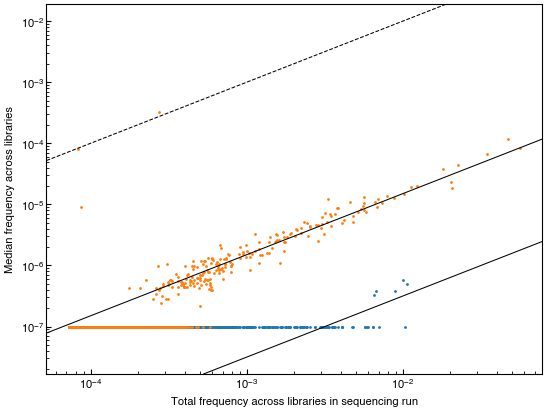

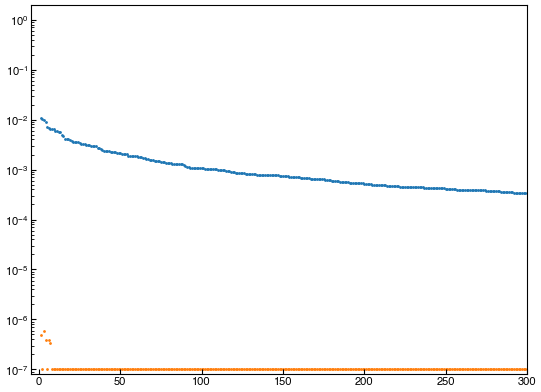

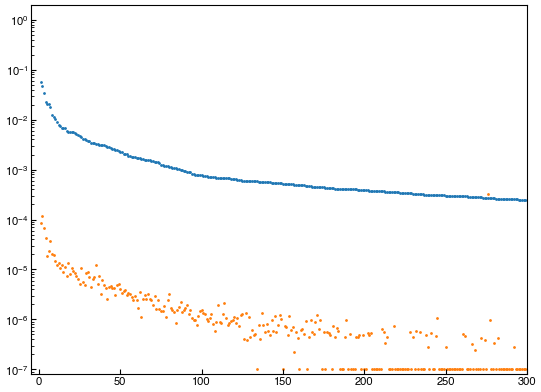

In [3]:
scatter_fig, scatter_ax = plt.subplots()
scatter_ax.axline( (10**-3, 10**-3), (10**-2, 10**-2), color='black', linestyle='dashed')
scatter_ax.set_xlabel('Total frequency across libraries in sequencing run')
scatter_ax.set_ylabel('Median frequency across libraries')


og_seq_array = np.array(list(vivo_array) + list(vitro_array))
og_seq_depths = np.array(list(vivo_depths) + list(vitro_depths))

for seqrun_array, seqrun_depths, rescale in [(og_seq_array, og_seq_depths,10**-4.5), 
                                             (reseq_array, reseq_depths,  1.5*10**(-3))]:
    seqrun_bc_tot_freqs = seqrun_array.sum(axis=0) / seqrun_depths[:, 0].sum()
    sorting = np.argsort(seqrun_bc_tot_freqs)[::-1]

    lib_freqs = np.einsum('ij,i->ij', seqrun_array, seqrun_depths[:, 0]**-1.)
    median_freqs = np.percentile(lib_freqs, 50, axis=0)[sorting]
    median_freqs[median_freqs == 0] = 1e-7
    upper_decile = np.percentile(lib_freqs, 70, axis=0)[sorting]
    upper_decile[upper_decile == 0] = 1e-7
    lower_decile = np.percentile(lib_freqs, 30, axis=0)[sorting]
    lower_decile[lower_decile == 0] = 1e-7


    print(list(zip(lower_decile, median_freqs, upper_decile)))
    scatter_ax.scatter(seqrun_bc_tot_freqs[sorting[:1000]], median_freqs[:1000], s=1)

    scatter_ax.axline( (10**-3, rescale*10**-3), (10**-2, rescale*10**-2), color='black')
    scatter_ax.set_yscale('log')
    scatter_ax.set_xscale('log')

    rank_fig, rank_ax = plt.subplots()
    rank_ax.scatter(np.arange(len(sorting))+1, seqrun_bc_tot_freqs[sorting],s=1)
    rank_ax.scatter(np.arange(len(sorting))+1, median_freqs,s=1)
    rank_ax.set_yscale('log')
    # ax.set_xscale('log')
    rank_ax.set_xlim(-5, 300)
    rank_ax.set_ylim(0.8*10**-7, 2)



# Estimate index-hopping at an individual library level

no detected barcodes, m= 6.868642063414408e-06
no detected barcodes, m= 4.178484642430934e-06
no detected barcodes, m= 1.6917197037697664e-06
no detected barcodes, m= 9.843778823010116e-06
no detected barcodes, m= 0.0011326957054208987
no detected barcodes, m= 7.068378914020616e-06
no detected barcodes, m= 2.6425444895527843e-05
no detected barcodes, m= 1.4978627222142862e-05
no detected barcodes, m= 0.00037508021421338517
no detected barcodes, m= 4.82534993771961e-05
no detected barcodes, m= 4.403547769163898e-05
no detected barcodes, m= 9.598622187978746e-05
no detected barcodes, m= 5.725327177269636e-05
no detected barcodes, m= 0.19307707842845032
no detected barcodes, m= 0.11079807530848985
no detected barcodes, m= 5.310323763532025e-05
no detected barcodes, m= 2.8346030374772226e-05
no detected barcodes, m= 0.00016651822057092545
no detected barcodes, m= 1.64335212686393e-05
no detected barcodes, m= 6.2709395184184e-05
no detected barcodes, m= 3.882902291322409e-05
no detected bar

/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_6443/737658463.py:76: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax2.set_yscale('log')


no detected barcodes, m= 0.001220664157995255
no detected barcodes, m= 0.0007157294375159145
no detected barcodes, m= 0.0005978361623745766
no detected barcodes, m= 0.0007589653815981303
no detected barcodes, m= 0.0016991412972160072
no detected barcodes, m= 0.02137722832643369
no detected barcodes, m= 0.04814154236741274
no detected barcodes, m= 0.037867791325863424
no detected barcodes, m= 0.06661273945539696
no detected barcodes, m= 0.03427558435071821
no detected barcodes, m= 0.023588386682301867
no detected barcodes, m= 0.023888842720547213
no detected barcodes, m= 0.01246757501240913
no detected barcodes, m= 0.0008256286931497221
no detected barcodes, m= 0.010131846825450494
no detected barcodes, m= 0.03642531334634949
no detected barcodes, m= 0.03339777674122592
no detected barcodes, m= 0.02435326983072454
no detected barcodes, m= 0.03478661772383153
no detected barcodes, m= 0.00754453579227608
no detected barcodes, m= 0.0019628943710601286
no detected barcodes, m= 0.02795187346

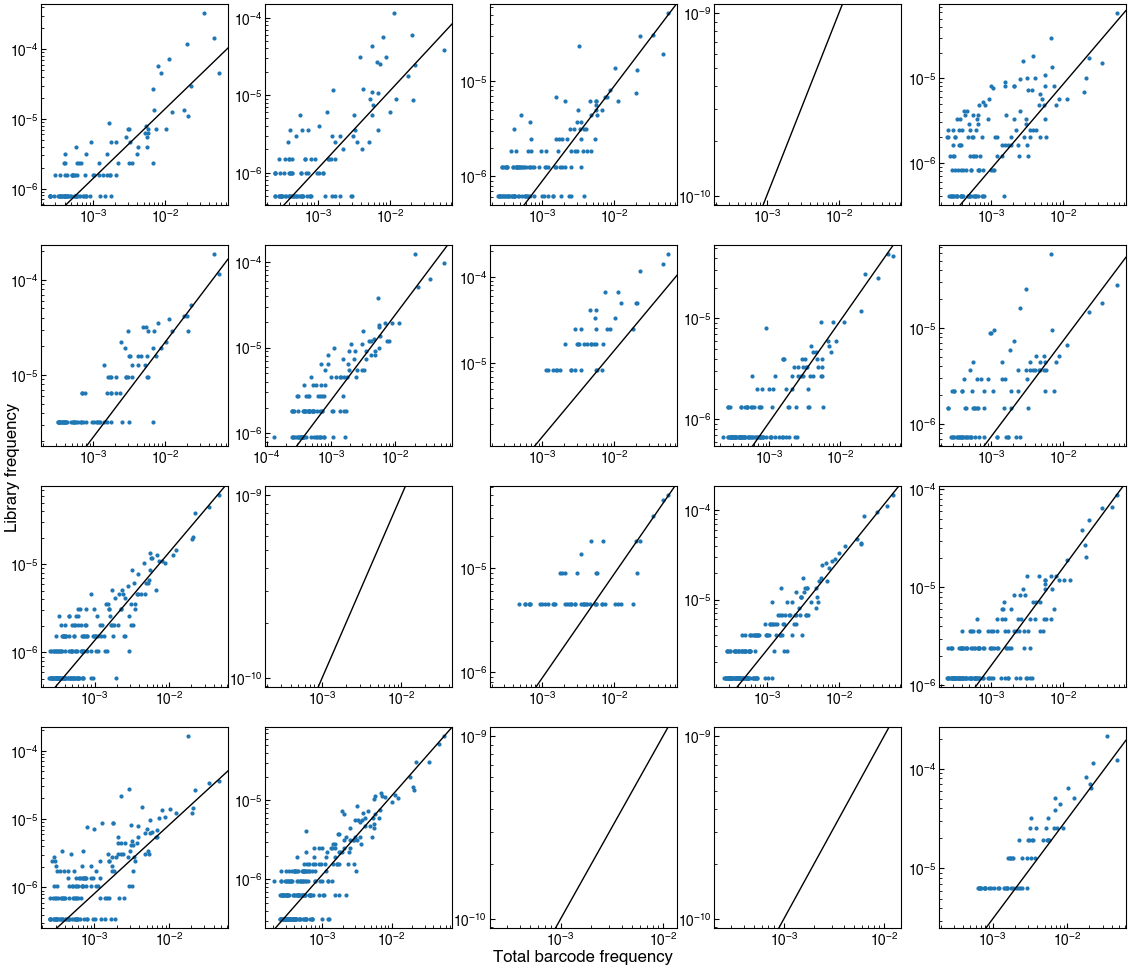

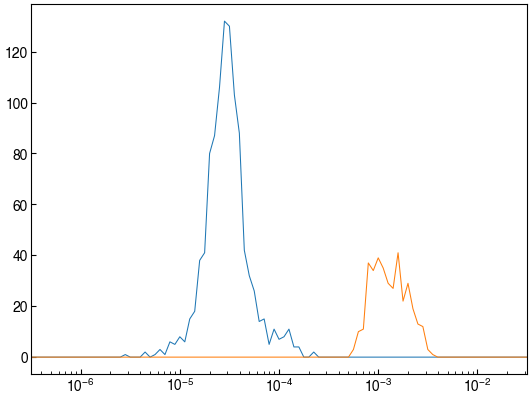

In [16]:
### for original sequencing run, index-hopping is much lower and most of the run-wide barcodes are measured at 0 in each library
##

og_seq_array = np.array(list(vivo_array) + list(vitro_array))
og_seq_depths = np.array(list(vivo_depths) + list(vitro_depths))
og_seq_tot_freqs = og_seq_array.sum(axis=0) / og_seq_depths[:, 0].sum()
og_seq_sorting = np.argsort(og_seq_tot_freqs)[::-1]
og_seq_tot_freqs = og_seq_tot_freqs[og_seq_sorting]   

reseq_tot_freqs = reseq_array.sum(axis=0) / reseq_depths[:, 0].sum()
reseq_sorting = np.argsort(reseq_tot_freqs)[::-1]
reseq_tot_freqs = reseq_tot_freqs[reseq_sorting]


max_bc = 300

vivo_hopping_rates = np.zeros(len(vivo_array))
vitro_hopping_rates = np.zeros(len(vitro_array))
reseq_hopping_rates = np.zeros(len(reseq_array))
barcode_hopping_rates = {'vivo': vivo_hopping_rates, 'vitro': vitro_hopping_rates, 'reseq': reseq_hopping_rates}
hopping_inference_data = {}


## example libraries 
n_examples = 20
ex_per_row = 5
z=0
fig2 = plt.figure(figsize=(14, 12))
gs = fig2.add_gridspec(n_examples//ex_per_row +  (n_examples%ex_per_row > 0), ex_per_row)
outer_ax = fig2.add_subplot(111, frameon=False)
util.turn_off_ax(outer_ax)
outer_ax.set_xlabel('Total barcode frequency', fontsize=12, labelpad=15)
outer_ax.set_ylabel('Library frequency', fontsize=12, labelpad=15)
example_libraries = sorted(rnd.choice(len(reseq_array), n_examples, replace=False))


for arr_name, run_tot_reads, run_tot_sorting in [('vivo', og_seq_array[:, og_seq_sorting].sum(axis=0), og_seq_sorting),
                                                 ('vitro', og_seq_array[:, og_seq_sorting].sum(axis=0), og_seq_sorting),
                                                 ('reseq', reseq_array[:, reseq_sorting].sum(axis=0), reseq_sorting)]:
   read_arr, read_depths = barcode_arrays[arr_name]
   run_tot_depth = run_tot_reads.sum()
   freq_arr = np.einsum('ij,i->ij', read_arr, read_depths[:, 0]**-1.)

   

   for i, library in enumerate(freq_arr):
      lib_size = read_depths[i, 0]
      lib_freqs = library[run_tot_sorting] #sort on the whole sequencing run
      
      run_tot_freqs = (run_tot_reads - read_arr[i]) / (run_tot_depth- read_arr[i].sum())
      # run_tot_freqs = run_tot_reads[exclude_i].sum(axis=0) / run_tot_reads[exclude_i].sum()

      valid_bool = np.full(max_bc, True)  
      valid_bool[lib_freqs[:max_bc] > run_tot_freqs[:max_bc]/100] = False # exclude barcodes that are likely genuinely represented in the library
      est_indexhop_rate, uncertainty, density, errs, bins, n_barcodes_per_bin = shared.migration_inference_by_pdetected((run_tot_freqs[:max_bc], 10**12), 
                                                                                       (np.zeros(max_bc), 10**12), 
                                                                                       (lib_freqs[:max_bc], lib_size), 
                                                                                       valid_bool, recip_floor=0, binspace=np.logspace(-5,0,51), pseudocount=0)

      if est_indexhop_rate == 0 or est_indexhop_rate == np.nan or uncertainty==0: ## these are the low-depth libraries without reads
         est_indexhop_rate = 10**-7
         # low_contam.add(i)
      barcode_hopping_rates[arr_name][i] = est_indexhop_rate
      hopping_inference_data[(arr_name, i)] = {'included_indices': run_tot_sorting[:max_bc],
                                               'run_freqs': run_tot_freqs[:max_bc],
                                               'lib_freqs': lib_freqs[:max_bc],
                                               'valid_bool': valid_bool}


      if arr_name == 'reseq' and i in example_libraries:
      # if total_index_hopped_rate > 1e-3 and z  < n_examples:   
         ax2 = fig2.add_subplot(gs[z//ex_per_row, z%ex_per_row])
         ax2.scatter( run_tot_freqs[:max_bc][valid_bool], lib_freqs[:max_bc][valid_bool], s=4 )


         ax2.set_yscale('log')
         ax2.set_xscale('log')
         ax2.axline( (10**-3, 10**-3 * est_indexhop_rate), (10**-2, 10**-2 * est_indexhop_rate), color='black', lw=1)

         # ax2.text(0.9, 0.1, f'Library {col_id_map["reseq"][i]}\ndepth={lib_size}\nrate={total_index_hopped_rate:.1e}', va='bottom', ha='right', transform=ax2.transAxes)
         # ax2.set_ylim(10**-2.5, 2)
         z+=1

fig, ax = plt.subplots()
og_seq_hopping = np.array(list(barcode_hopping_rates['vivo']) + list(barcode_hopping_rates['vitro']))
og_seq_depths
density, bins = np.histogram(og_seq_hopping[og_seq_depths[:,0] > 1e4], bins=np.logspace(-7, 0, 141))
ax.plot(bins[:-1], density, label='Original sequencing run')

# og_seq_hopping = np.array(list(barcode_hopping_rates['vitro']))
# density, bins = np.histogram(og_seq_hopping[vitro_depths[:,0] > 1e4], bins=np.logspace(-7, 0, 141))
# ax.plot(bins[:-1], density, label='Original sequencing run')

density, bins = np.histogram(barcode_hopping_rates['reseq'][reseq_depths[:,0] > 1e4], bins=np.logspace(-7, 0, 141))
ax.plot(bins[:-1], density, label='Resequencing run')
ax.set_xscale('log')
ax.set_xlim(10**-6.5, 10**-1.5)

with open(f'{pickled_dir}/barcode_index_hopping_rates.pkl', 'wb') as f:
    pickle.dump(barcode_hopping_rates, f)





# Use input libraries to label barcodes by inoculum

In [7]:
row_ids = {}

# P1_libs = [('E1', 'P1')]#, ('E2', 'S1'), ('E2', 'S1delay'), ('E2', 'S2'), ('E2', 'S2delay'), ('E2', 'S5'), ('E2', 'S5delay'),]
# P2_libs = [('E1', 'P2')]#, ('E2', 'S3'), ('E2', 'S3delay'), ('E2', 'S4'), ('E2', 'S4delay')]

P1_libs = [('E1', 'P1'), ('E2', 'S1'), ('E2', 'S1delay'), ('E2', 'S2'), ('E2', 'S2delay'), ('E2', 'S5'), ('E2', 'S5delay'), 
           ('EV', 'V1'), ('EV', 'V2'), ('EV', 'V3')]
P2_libs = [('E1', 'P2'), ('E2', 'S3'), ('E2', 'S3delay'), ('E2', 'S4'), ('E2', 'S4delay'),
           ('EV', 'V4'), ('EV', 'V5'), ('EV', 'V6')]

# P1_libs = [('E1', 'P1'), ('E2', 'S1'), ('E2', 'S1delay'), ('E2', 'S2'), ('E2', 'S2delay'), ('E2', 'S5'), ('E2', 'S5delay')]
# P2_libs = [('E1', 'P2'), ('E2', 'S3'), ('E2', 'S3delay'), ('E2', 'S4'), ('E2', 'S4delay')]

S1_libs = [('E2', 'S1'), ('E2', 'S1delay'), ('EV', 'V1')]
S2_libs = [('E2', 'S2'), ('E2', 'S2delay'), ('EV', 'V3')]
S3_libs = [('E2', 'S3'), ('E2', 'S3delay'), ('EV', 'V4')]
S4_libs = [('E2', 'S4'), ('E2', 'S4delay'), ('EV', 'V6')]
S5_libs = [('E2', 'S5'), ('E2', 'S5delay')]
V1_libs = [('EV', 'V1')]
V2_libs = [('EV', 'V2')]
V3_libs = [('EV', 'V3')]
V4_libs = [('EV', 'V4')]
V5_libs = [('EV', 'V5')]
V6_libs = [('EV', 'V6')]

P1_indices = []
P1_names = []
P2_indices = []
P2_names = []
S1_indices, S1_names = [], []
S2_indices, S2_names = [], []
S3_indices, S3_names = [], []
S4_indices, S4_names = [], []
S5_indices, S5_names = [], []
V1_indices, V1_names = [], []
V2_indices, V2_names = [], []
V3_indices, V3_names = [], []
V4_indices, V4_names = [], []
V5_indices, V5_names = [], []
V6_indices, V6_names = [], []



for (libs, lib_indices, lib_names) in [(P1_libs, P1_indices, P1_names), 
                                       (P2_libs, P2_indices, P2_names),
                                       (S1_libs, S1_indices, S1_names),
                                       (S2_libs, S2_indices, S2_names),
                                       (S3_libs, S3_indices, S3_names),
                                       (S4_libs, S4_indices, S4_names),
                                       (S5_libs, S5_indices, S5_names),
                                       (V1_libs, V1_indices, V1_names),
                                       (V2_libs, V2_indices, V2_names),
                                       (V3_libs, V3_indices, V3_names),
                                       (V4_libs, V4_indices, V4_names),
                                       (V5_libs, V5_indices, V5_names),
                                       (V6_libs, V6_indices, V6_names)]:
    for lib in libs:
        for (arr_name, arr_index) in library_array_map[lib]:
            if arr_name != 'reseq':
                continue
            # lib_depth = reseq_depths[arr_index,0]
            lib_depth = barcode_arrays[arr_name][1][arr_index,0]
            if lib_depth < 10**4:
                continue
            
            lib_indices.append( (arr_name, arr_index) )
            # lib_indices.append( arr_index )
            lib_names.append( lib) 

# print( list(zip(P1_names, reseq_depths[P1_indices,0])) )
# print( list(zip(P2_names, reseq_depths[P2_indices,0])) )

In [17]:
poisson = scipy.stats.poisson
def poisson_pval(counts, expectations):
    pvals = poisson.sf(counts-1, expectations) # survival function *including the observed count* 
    return pvals

def calc_barcode_specific_pvals_within_libraries(list_of_list_bc_tot_freqs, 
                                                 list_of_list_of_libraries, 
                                                 list_of_list_of_depths,
                                                 list_of_list_of_index_hopping,
                                                 min_pval = 1e-12):
    # libraries of barcode reads in list_of_list and bc_tot_freqs should be sorted equivalently
    list_of_combined_pvals = [] # will have same dimension of list_of_list_of_libraries
    list_of_uncombined_pvals = [] 
    for (libraries, depths, index_hopping_rates, bc_tot_freqs) in zip(list_of_list_of_libraries, 
                                                        list_of_list_of_depths,
                                                        list_of_list_of_index_hopping,
                                                        list_of_list_bc_tot_freqs):
        counts = np.array(libraries)
        depths = np.array(depths)
        Dnom, Deff = depths[:, 0], depths[:, 1]
        bc_tot_freqs = np.array(bc_tot_freqs)

        expectation = np.einsum('i,i,ij->ij', Dnom, index_hopping_rates, bc_tot_freqs)
        

        pvals = poisson_pval(counts, expectation)
        _, combined_pvals = scipy.stats.combine_pvalues(pvals, method='fisher', axis=0) #axis=0 is by barcode
        combined_pvals[combined_pvals < min_pval] = min_pval

        pvals[pvals < min_pval] = min_pval

        list_of_combined_pvals.append(combined_pvals)
        list_of_uncombined_pvals.append(pvals)
    return list_of_combined_pvals, list_of_uncombined_pvals
    
def sort_barcodes_into_pools(list_of_barcode_pvals,  #
                  min_pval,  #FDR-adjusted min_pval
                  ambiguous_cutoff = 1e-3): 
    arr_of_barcode_pvals = np.array(list_of_barcode_pvals)
    pool_bools = []
    shared_bool = np.full(len(list_of_barcode_pvals[0]), False)
    for i in range(len(arr_of_barcode_pvals)):
        focal_pvals = list_of_barcode_pvals[i]
        nonfocal_pvals = np.array([pvals for j, pvals in enumerate(list_of_barcode_pvals) if j != i])
        pooli_bool = (focal_pvals < min_pval) & ((nonfocal_pvals > ambiguous_cutoff).sum(axis=0) == len(nonfocal_pvals))
        pool_bools.append(pooli_bool)
    pool_bools = np.array(pool_bools)
    shared_bool[ ((arr_of_barcode_pvals < ambiguous_cutoff).sum(axis=0) > 1) & (np.min(arr_of_barcode_pvals, axis=0) < min_pval) ] = True
    ambiguous_bool = (pool_bools.sum(axis=0) + shared_bool) == 0 

    z = np.arange(len(shared_bool))
    pool_bool_and_indices = [(pool_bool, z[pool_bool]) for pool_bool in pool_bools] + [(shared_bool, z[shared_bool]), (ambiguous_bool, z[ambiguous_bool])]
    return pool_bool_and_indices    
    

In [18]:
## group by P1 libraries and P2 libraries
# 3 way test --> prob-index hopping

## for each barcode, determine likelihood of counts conditioned on index-hopping

unsorted_orig_freqs = og_seq_array.sum(axis=0) / og_seq_depths[:, 0].sum()
unsorted_reseq_freqs = reseq_array.sum(axis=0) / reseq_depths[:, 0].sum()

sorting = np.argsort(unsorted_reseq_freqs)[::-1]

tot_freqs = {'vivo':unsorted_orig_freqs, 'vitro': unsorted_orig_freqs, 'reseq': unsorted_reseq_freqs}


E1_counts = [[barcode_arrays[arr_name][0][idx] for (arr_name, idx) in set_indices] for set_indices in [P1_indices, P2_indices]]
E1_depths = [[barcode_arrays[arr_name][1][idx] for (arr_name, idx) in set_indices] for set_indices in [P1_indices, P2_indices]]
E1_index_hopping = [[barcode_hopping_rates[arr_name][idx] for (arr_name, idx) in set_indices] for set_indices in [P1_indices, P2_indices]]
E1_ref_tot_freqs = [[tot_freqs[arr_name] for (arr_name, idx) in set_indices] for set_indices in [P1_indices, P2_indices]]

E2_counts = [[barcode_arrays[arr_name][0][idx] for (arr_name, idx) in set_indices] for set_indices in [S1_indices, S2_indices, S3_indices, S4_indices, S5_indices]]
E2_depths = [[barcode_arrays[arr_name][1][idx] for (arr_name, idx) in set_indices] for set_indices in [S1_indices, S2_indices, S3_indices, S4_indices, S5_indices]]
E2_index_hopping = [[barcode_hopping_rates[arr_name][idx] for (arr_name, idx) in set_indices] for set_indices in [S1_indices, S2_indices, S3_indices, S4_indices, S5_indices]]
E2_ref_tot_freqs = [[tot_freqs[arr_name] for (arr_name, idx) in set_indices] for set_indices in [S1_indices, S2_indices, S3_indices, S4_indices, S5_indices]]


EV_counts = [[barcode_arrays[arr_name][0][idx] for (arr_name, idx) in set_indices] for set_indices in [V1_indices, V2_indices, V3_indices, V4_indices, V5_indices, V6_indices]]
EV_depths = [[barcode_arrays[arr_name][1][idx] for (arr_name, idx) in set_indices] for set_indices in [V1_indices, V2_indices, V3_indices, V4_indices, V5_indices, V6_indices]]
EV_index_hopping = [[barcode_hopping_rates[arr_name][idx] for (arr_name, idx) in set_indices] for set_indices in [V1_indices, V2_indices, V3_indices, V4_indices, V5_indices, V6_indices]]
EV_ref_tot_freqs = [[tot_freqs[arr_name] for (arr_name, idx) in set_indices] for set_indices in [V1_indices, V2_indices, V3_indices, V4_indices, V5_indices, V6_indices]]


max_pval_to_include = 1e-3 / len(unsorted_reseq_freqs)
min_pval_to_exclude = 1e-3


P12_combined, P12_uncombined  = calc_barcode_specific_pvals_within_libraries(E1_ref_tot_freqs,
                                                                        E1_counts, 
                                                                        E1_depths, 
                                                                        E1_index_hopping)
P1_combined, P2_combined = P12_combined

[(P1_bc_bool, P1_bc_indices), 
 (P2_bc_bool, P2_bc_indices), 
 (E1_shared_bool, E1_shared_indices),
 (E1_ambiguous_bool, E1_ambiguous_indices)] = sort_barcodes_into_pools(P12_combined, 
                                                                       max_pval_to_include, 
                                                                       min_pval_to_exclude)

S15_combined, S15_uncombined = calc_barcode_specific_pvals_within_libraries(E2_ref_tot_freqs,
                                                                        E2_counts, 
                                                                        E2_depths,
                                                                        E2_index_hopping)


S14_combined = [S15_combined[0], S15_combined[1], S15_combined[2], S15_combined[3]]
[(S1_bc_bool, S1_bc_indices), 
 (S2_bc_bool, S2_bc_indices), 
 (S3_bc_bool, S3_bc_indices),
 (S4_bc_bool, S4_bc_indices),
 (E2_shared_bool, E2_shared_indices),
 (E2_ambiguous_bool, E2_ambiguous_indices)] = sort_barcodes_into_pools(S14_combined,
                                                                       max_pval_to_include, 
                                                                       min_pval_to_exclude)

S5_combined = [S15_combined[4]]
[(S5_bc_bool, S5_bc_indices), # treat separately because it overlaps with S1 and S2 
  (S5_shared_bool, S5_shared_indices),
 (S5_ambiguous_bool, S5_ambiguous_indices)] = sort_barcodes_into_pools(S5_combined,
                                                                       max_pval_to_include, 
                                                                       min_pval_to_exclude)
                                                                       
# S5_bc_bool[E2_shared_bool] = False
# S5_bc_indices = np.arange(len(S5_bc_bool))[S5_bc_bool]
E2_shared_bool[S5_bc_bool] = False
E2_shared_indices = np.arange(len(E2_shared_bool))[E2_shared_bool]
E2_ambiguous_bool[S5_bc_bool] = False
E2_ambiguous_indices = np.arange(len(E2_ambiguous_bool))[E2_ambiguous_bool]


EV_combined, EV_uncombined = calc_barcode_specific_pvals_within_libraries(EV_ref_tot_freqs,
                                                                        EV_counts, 
                                                                        EV_depths,
                                                                        EV_index_hopping)

[(V1_bc_bool, V1_bc_indices), 
 (V2_bc_bool, V2_bc_indices), 
 (V3_bc_bool, V3_bc_indices),
 (V4_bc_bool, V4_bc_indices),
 (V5_bc_bool, V5_bc_indices),
 (V6_bc_bool, V6_bc_indices),
 (EV_shared_bool, EV_shared_indices),
 (EV_ambiguous_bool, EV_ambiguous_indices)] = sort_barcodes_into_pools(EV_combined, 
                                                                       max_pval_to_include, 
                                                                       min_pval_to_exclude)


n_examples = 20
ex_per_row = 5
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(n_examples//ex_per_row +  (n_examples%ex_per_row > 0), ex_per_row)
outer_ax = fig.add_subplot(111, frameon=False)
util.turn_off_ax(outer_ax)
outer_ax.set_xlabel('Library index', fontsize=12, labelpad=21)
outer_ax.set_ylabel('P-val in library', fontsize=12, labelpad=21)
z = 0

P1_uncombined_sorted = np.array([uncombined[sorting] for uncombined in P12_uncombined[0]])
P2_uncombined_sorted = np.array([uncombined[sorting] for uncombined in P12_uncombined[1]])

random_bcs = list(range(0,10)) + list(range(100, 110))
for z, bc_index in enumerate(range(0, 20)):
    bc_tot_freq = unsorted_reseq_freqs[sorting][bc_index]
    P1_pvals = P1_uncombined_sorted[:, bc_index]
    P2_pvals = P2_uncombined_sorted[:, bc_index]
    
    ax = fig.add_subplot(gs[z//ex_per_row, z%ex_per_row])
    ax.plot( P1_pvals, marker='^', label='P1 libraries')
    ax.plot( P2_pvals, marker='v', label='P2 libraries')
    ax.set_yscale('log')
    ax.set_ylim( 10**-21, 10)
    ax.set_title(f'Barcode {sorting[bc_index]}: f_tot = {bc_tot_freq:.2e}', fontsize=10)
    if z == 0:
        ax.legend( frameon=False, fontsize=8, loc=4)
    ax.set_xticks(range(0, 11))
    ax.axhline(1, color='black', linestyle='dashed')
    

fig.savefig('plots/poisson_pvals_examples.png', dpi=300)

    # ax.axhline(bc_tot_freq)
    # ax.plot( P1_counts / P1_depths, marker='^', linestyle='dotted', color='black')
    # ax.plot( P2_counts / P2_depths, marker='v', linestyle='dotted', color='black')

/Users/daniel/.julia/conda/3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9324: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * np.sum(np.log(pvalues))


In [19]:
barcode_pool_assignments = {
    'P1': [P1_bc_indices, P1_bc_bool],
    'P2': [P2_bc_indices, P2_bc_bool],
    'E1_shared': [E1_shared_indices, E1_shared_bool],
    'E1_ambiguous': [E1_ambiguous_indices, E1_ambiguous_bool],
    'S1': [S1_bc_indices, S1_bc_bool], 
    'S2': [S2_bc_indices, S2_bc_bool], 
    'S3': [S3_bc_indices, S3_bc_bool], 
    'S4': [S4_bc_indices, S4_bc_bool], 
    'S5': [S5_bc_indices, S5_bc_bool], 
    'E2_shared': [E2_shared_indices, E2_shared_bool],
    'E2_ambiguous': [E2_ambiguous_indices, E2_ambiguous_bool],
    'V1': [V1_bc_indices, V1_bc_bool],
    'V2': [V2_bc_indices, V2_bc_bool],
    'V3': [V3_bc_indices, V3_bc_bool],
    'V4': [V4_bc_indices, V4_bc_bool],
    'V5': [V5_bc_indices, V5_bc_bool],
    'V6': [V6_bc_indices, V6_bc_bool],
    'EV_shared': [EV_shared_indices, EV_shared_bool],
    'EV_ambiguous': [EV_ambiguous_indices, EV_ambiguous_bool]}
    

for barcode_pool, (bc_indices, bool_array) in barcode_pool_assignments.items():
    print(barcode_pool, len(bc_indices))
print('\n\n')
###
set_items = list(barcode_pool_assignments.items())
for i, (setx_name, (setx_indices, setx_bool)) in enumerate(set_items[:-1]):
    for j in range(i+1, len(set_items)):
        sety_name, (sety_indices, sety_bool) = set_items[j]

        print(f'{setx_name} & {sety_name}:', len(set(setx_indices) & set(sety_indices)))

P1 34116
P2 34844
E1_shared 45
E1_ambiguous 14058
S1 16646
S2 17385
S3 18100
S4 16695
S5 190
E2_shared 58
E2_ambiguous 14148
V1 8455
V2 11744
V3 11584
V4 11337
V5 11448
V6 10940
EV_shared 113
EV_ambiguous 17442



P1 & P2: 0
P1 & E1_shared: 0
P1 & E1_ambiguous: 0
P1 & S1: 16285
P1 & S2: 17048
P1 & S3: 0
P1 & S4: 0
P1 & S5: 155
P1 & E2_shared: 25
P1 & E2_ambiguous: 752
P1 & V1: 8389
P1 & V2: 11380
P1 & V3: 11354
P1 & V4: 0
P1 & V5: 0
P1 & V6: 0
P1 & EV_shared: 57
P1 & EV_ambiguous: 2936
P2 & E1_shared: 0
P2 & E1_ambiguous: 0
P2 & S1: 0
P2 & S2: 0
P2 & S3: 17825
P2 & S4: 16476
P2 & S5: 2
P2 & E2_shared: 17
P2 & E2_ambiguous: 526
P2 & V1: 0
P2 & V2: 0
P2 & V3: 0
P2 & V4: 11140
P2 & V5: 11312
P2 & V6: 10765
P2 & EV_shared: 32
P2 & EV_ambiguous: 1595
E1_shared & E1_ambiguous: 0
E1_shared & S1: 1
E1_shared & S2: 4
E1_shared & S3: 8
E1_shared & S4: 0
E1_shared & S5: 24
E1_shared & E2_shared: 16
E1_shared & E2_ambiguous: 0
E1_shared & V1: 1
E1_shared & V2: 3
E1_shared & V3: 4
E1_shared & V4: 9

Total number of large, unspecified barcodes reaching high frequency in at least one mouse: 12
14 reaches large frequency in multiple E1 mice: [('E1', 1, 'ambiguous'), ('E1', 2, 'ambiguous'), ('E1', 4, 'ambiguous'), ('E1', 5, 'ambiguous'), ('E1', 6, 'ambiguous'), ('E1', 7, 'ambiguous')]
P2
41 reaches large frequency in multiple E1 mice: [('E1', 6, 'ambiguous'), ('E1', 7, 'ambiguous'), ('E1', 8, 'ambiguous'), ('E1', 9, 'ambiguous'), ('E1', 10, 'ambiguous')]
P1
75 only reaches large frequency in one, singly-housed mous: [('E2', 2, 'shared')]
139 only reaches large frequency in one, singly-housed mous: [('E2', 2, 'shared')]
325 only reaches large frequency in one, singly-housed mous: [('E2', 2, 'shared')]
25217 only reaches large frequency in one, singly-housed mous: [('E2', 2, 'ambiguous')]
6 reaches large frequency in multiple E2 mice: [('E2', 3, 'shared'), ('E2', 4, 'shared'), ('E2', 5, 'shared')]
95 reaches large frequency in multiple E2 mice: [('E2', 3, 'shared'), ('E2', 13, 'shared')

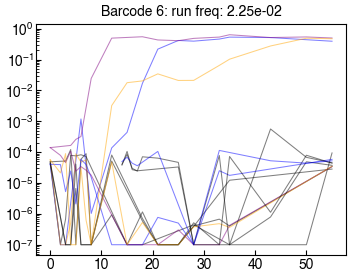

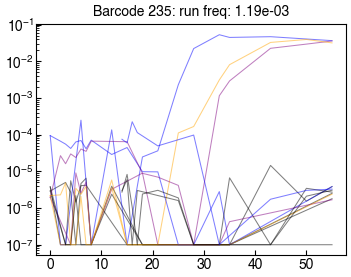

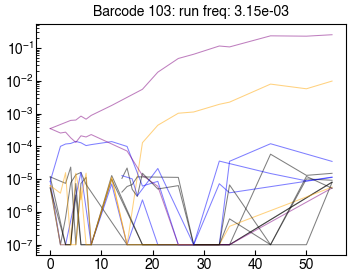

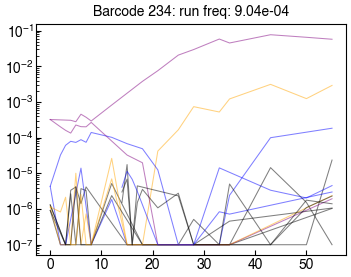

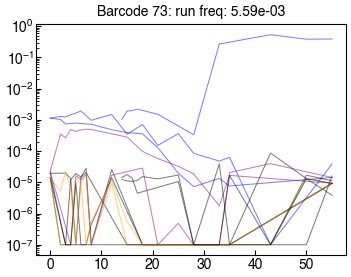

In [20]:
reload(shared)
## what fraction of pop do shared barcodes compose?
unspecified_large_barcodes = {}

for expt, mouse, shared_indices, ambiguous_indices in zip(['E1']*13 + ['E2']*15, 
                                       list(range(1,14)) + list(range(1,16)),
                                        [E1_shared_indices]*13 + [E2_shared_indices]*15,
                                        [E1_ambiguous_indices]*13 + [E2_ambiguous_indices]*15):
    days, reads, depths = shared.get_mouse_timecourse(expt, mouse)
    freqs = shared.calc_freqs(reads, depths)

    max_traj = np.max(freqs[:, shared_indices], axis=0)
    # print(f'{expt} {mouse} shared:', shared_indices[np.where(max_traj > 1e-2)[0]] )
    large_shared = shared_indices[np.where(max_traj > 1e-2)[0]]
    for idx in large_shared:
        if idx not in unspecified_large_barcodes:
            unspecified_large_barcodes[idx] = []
        unspecified_large_barcodes[idx].append((expt, mouse, 'shared'))

    max_traj = np.max(freqs[:, ambiguous_indices], axis=0)
    # print(f'{expt} {mouse} ambiguous:', ambiguous_indices[np.where(max_traj > 1e-2)[0]] )
    large_ambiguous = ambiguous_indices[np.where(max_traj > 1e-2)[0]]
    for idx in large_ambiguous:
        if idx not in unspecified_large_barcodes:
            unspecified_large_barcodes[idx] = []
        unspecified_large_barcodes[idx].append((expt, mouse, 'ambiguous'))

    # fig, ax = plt.subplots()
    # ax.plot( days, np.sum(freqs[:, shared_indices], axis=1))
    # ax.plot( days, np.sum(freqs[:, ambiguous_indices], axis=1))
    # ax.set_yscale('log')
    # ax.set_title(f'{expt} {mouse}')
            

print("Total number of large, unspecified barcodes reaching high frequency in at least one mouse:", len(unspecified_large_barcodes))
count = len(unspecified_large_barcodes)

for large_bc in list(unspecified_large_barcodes.keys()):
    (expt, mouse, bc_type) = unspecified_large_barcodes[large_bc][0]

    if len(unspecified_large_barcodes[large_bc]) == 1:
        if expt == 'E2' and mouse in [1,2,6,7,11,12]: #singly housed
            print(f"{large_bc} only reaches large frequency in one, singly-housed mous: {unspecified_large_barcodes[large_bc]}")

            
            if mouse in [1,6, 11]:
                inoc = 'S1'
            elif mouse in [2,7, 12]:
                inoc = 'S2'
            barcode_pool_assignments[inoc][1][large_bc] = True
            barcode_pool_assignments[inoc][0] = np.arange(len(barcode_pool_assignments[inoc][1]))[barcode_pool_assignments[inoc][1]]  
            barcode_pool_assignments["E2_ambiguous"][1][large_bc] = False
            barcode_pool_assignments["E2_ambiguous"][0] = np.arange(len(E2_ambiguous_bool))[barcode_pool_assignments["E2_ambiguous"][1]]
            barcode_pool_assignments["E2_shared"][1][large_bc] = False
            barcode_pool_assignments["E2_shared"][0] = np.arange(len(E2_shared_bool))[barcode_pool_assignments["E2_shared"][1]]

            del unspecified_large_barcodes[large_bc]
            count -= 1
            continue
    
    #otherwise, co-housed and we need to disambiguate
    if expt == 'E1':
        print(f"{large_bc} reaches large frequency in multiple E1 mice: {unspecified_large_barcodes[large_bc]}")
        fig, ax = plt.subplots( figsize=(4,3))

        for mouse in [1,2,3,4,5,6,7,8,9,10,11,12,13]:
            days, reads, depths = shared.get_mouse_timecourse(expt, mouse, include_pseudo_derepped=True)
            freqs = shared.calc_freqs(reads, depths) + 1e-7
                    
            if mouse in [1,2,3,4,5]:
                ax.plot(days, freqs[:, large_bc], alpha=0.5, color='blue')
            else:
                ax.plot(days, freqs[:, large_bc], alpha=0.5, color='orange')
            ax.set_yscale('log')
            
        when_reach_1p = []
        for mouse in [4,5,6,7]: #mixed plate cage
            days, reads, depths = shared.get_mouse_timecourse(expt, mouse, include_pseudo_derepped=True)
            freqs = shared.calc_freqs(reads, depths) + 1e-7

            try:
                t_idx = np.where(freqs[:, large_bc] > 1e-2)[0][0]
            except:
                continue
            when_reach_1p.append( [mouse, days[t_idx], freqs[t_idx,large_bc]] )
        when_reach_1p = np.array(when_reach_1p)
        
        argmin = np.argmin(when_reach_1p[:, 1])
        argmouse, min_time, ref_freq = when_reach_1p[argmin]

        freq_ratios = []
        opp_mice = {4:[6,7], 5:[6,7], 6:[4,5], 7:[4,5]}
        for mouse in opp_mice[argmouse]:
            days, reads, depths = shared.get_mouse_timecourse(expt, mouse, include_pseudo_derepped=True)
            freqs = shared.calc_freqs(reads, depths) + 1e-7
            first_time_after = np.where(days >= min_time)[0][0]

            comparison_freq = freqs[first_time_after, large_bc]
            freq_ratios.append( comparison_freq / ref_freq )

        # print(freq_ratios)
        if np.max(freq_ratios) < 1e-2:
            if argmouse in [4,5]:
                inoc = 'P2'
            else:
                inoc = 'P1'
            print(inoc)
            barcode_pool_assignments[inoc][1][large_bc] = True
            barcode_pool_assignments[inoc][0] = np.arange(len(P1_bc_bool))[barcode_pool_assignments[inoc][1]]

            barcode_pool_assignments["E1_ambiguous"][1][large_bc] = False
            barcode_pool_assignments["E1_ambiguous"][0] = np.arange(len(E1_ambiguous_bool))[barcode_pool_assignments["E1_ambiguous"][1]]
            barcode_pool_assignments["E1_shared"][1][large_bc] = False
            barcode_pool_assignments["E1_shared"][0] = np.arange(len(E1_shared_bool))[barcode_pool_assignments["E1_shared"][1]]

            del unspecified_large_barcodes[large_bc]
            count -= 1

    if expt == 'E2':
        print(f"{large_bc} reaches large frequency in multiple E2 mice: {unspecified_large_barcodes[large_bc]}")
        fig, ax = plt.subplots( figsize=(4,3))

        for mouse in [1,2,3,4,5,6,7,8,9,10,11,12,13]:
            days, reads, depths = shared.get_mouse_timecourse(expt, mouse, include_pseudo_derepped=True)
            freqs = shared.calc_freqs(reads, depths) + 1e-7
            
            if mouse in [1,2,6,7,11,12]:
                ax.plot(days, freqs[:, large_bc], alpha=0.5, color='black')
            elif mouse in [3,8,13]:
                ax.plot(days, freqs[:, large_bc], alpha=0.5, color='blue')
            elif mouse in [4,9, 14]:
                ax.plot(days, freqs[:, large_bc], alpha=0.5, color='purple')
            elif mouse in [5,10, 15]:
                ax.plot(days, freqs[:, large_bc], alpha=0.5, color='orange')
            ax.set_yscale('log')
            ax.set_title(f'Barcode {large_bc}: run freq: {unsorted_reseq_freqs[large_bc]:.2e}')
        
        originating_mice = []
        for cage in [(3,4,5), (8,9,10), (13, 14, 15)]:
            when_reach_1p = []
            for mouse in cage: #mixed plate cage
                days, reads, depths = shared.get_mouse_timecourse(expt, mouse, include_pseudo_derepped=True)
                freqs = shared.calc_freqs(reads, depths) + 1e-7

                try:
                    t_idx = np.where(freqs[:, large_bc] > 1e-2)[0][0]
                except:
                    continue
                when_reach_1p.append( [mouse, days[t_idx], freqs[t_idx,large_bc]] )
            when_reach_1p = np.array(when_reach_1p)
            if len(when_reach_1p) == 0:
                continue
            argmin = np.argmin(when_reach_1p[:, 1])
            argmouse, min_time, ref_freq = when_reach_1p[argmin]

            freq_ratios = []
            opp_mice = {3:[4,5], 4:[3,5], 5:[3,4], 8:[9,10], 9:[8,10], 10:[8,9], 13:[14,15], 14:[13,15], 15:[13,14]}
            for mouse in opp_mice[argmouse]:
                days, reads, depths = shared.get_mouse_timecourse(expt, mouse, include_pseudo_derepped=True)
                freqs = shared.calc_freqs(reads, depths) + 1e-7
                first_time_after = np.where(days >= min_time)[0][0]

                comparison_freq = freqs[first_time_after, large_bc]
                freq_ratios.append( comparison_freq / ref_freq )
            
            if np.max(freq_ratios) < 1e-1:
                originating_mice.append(argmouse)
            else:
                print('CONFLICT!')
        
        originating_mice = np.array(originating_mice)
        if np.any(originating_mice % 5 - originating_mice[0] % 5):
            print('CONFLICT!')
            continue
        else:
            if originating_mice[0] % 5 == 3:
                inoc = 'S3'
            elif originating_mice[0] % 5 == 4:
                inoc = 'S4'
            elif originating_mice[0] % 5 == 0:
                inoc = 'S5'
            else:
                print('CONFLICT!')
                continue
            barcode_pool_assignments[inoc][1][large_bc] = True
            barcode_pool_assignments[inoc][0] = np.arange(len(barcode_pool_assignments[inoc][1]))[barcode_pool_assignments[inoc][1]]  
            barcode_pool_assignments["E2_ambiguous"][1][large_bc] = False
            barcode_pool_assignments["E2_ambiguous"][0] = np.arange(len(E2_ambiguous_bool))[barcode_pool_assignments["E2_ambiguous"][1]]
            barcode_pool_assignments["E2_shared"][1][large_bc] = False
            barcode_pool_assignments["E2_shared"][0] = np.arange(len(E2_shared_bool))[barcode_pool_assignments["E2_shared"][1]]

            del unspecified_large_barcodes[large_bc]
            count -= 1

assert count == 0 # all accounted across in vivo experiments




#### do the same for in vitro experiments
shared_indices = EV_shared_indices
ambiguous_indices = EV_ambiguous_indices
for m, medium in enumerate(shared.ordered_media[:]):
    wells = shared.medium_to_well_map[medium]
    
    for r, (plate_well, bc_set) in enumerate(wells):
        plate = int(plate_well.split('_')[0].strip('p'))
        well = plate_well.split('_')[1]
        inoc = shared.well_to_inoc_map[plate_well][1]

        print(plate_well, inoc)

        try:
            days, reads, depths = shared.get_mouse_timecourse('EV', plate_well)
        except:
            continue
        freqs = shared.calc_freqs(reads, depths)

        max_traj = np.max(freqs[:, shared_indices], axis=0)
        # print(f'{expt} {mouse} shared:', shared_indices[np.where(max_traj > 1e-2)[0]] )
        large_shared = shared_indices[max_traj > 1e-2]
        for idx, max_f in zip(large_shared, max_traj[max_traj > 1e-2]):
            if idx not in unspecified_large_barcodes:
                unspecified_large_barcodes[idx] = []
            unspecified_large_barcodes[idx].append(('EV', plate_well, inoc, max_f, 'shared'))

        max_traj = np.max(freqs[:, ambiguous_indices], axis=0)
        # print(f'{expt} {mouse} ambiguous:', ambiguous_indices[np.where(max_traj > 1e-2)[0]] )
        large_ambiguous = ambiguous_indices[max_traj > 1e-2]
        for idx, max_f in zip(large_ambiguous, max_traj[max_traj > 1e-2]):
            if idx not in unspecified_large_barcodes:
                unspecified_large_barcodes[idx] = []
            unspecified_large_barcodes[idx].append(('EV', plate_well, inoc, max_f, 'ambiguous'))
    
print("Total number of large, unspecified barcodes reaching high frequency in at least one mouse:", len(unspecified_large_barcodes))
count = len(unspecified_large_barcodes)

for large_bc in list(unspecified_large_barcodes.keys()):
    print(large_bc, unspecified_large_barcodes[large_bc])
    if len(unspecified_large_barcodes[large_bc]) == 1: 
        print(f"{large_bc} only reaches large frequency in one well: {unspecified_large_barcodes[large_bc]}")
        inoc = unspecified_large_barcodes[large_bc][0][2]
        barcode_pool_assignments[inoc][1][large_bc] = True
        barcode_pool_assignments[inoc][0] = np.arange(len(barcode_pool_assignments[inoc][1]))[barcode_pool_assignments[inoc][1]]  
        barcode_pool_assignments["EV_ambiguous"][1][large_bc] = False
        barcode_pool_assignments["EV_ambiguous"][0] = np.arange(len(EV_ambiguous_bool))[barcode_pool_assignments["EV_ambiguous"][1]]
        barcode_pool_assignments["EV_shared"][1][large_bc] = False
        barcode_pool_assignments["EV_shared"][0] = np.arange(len(EV_shared_bool))[barcode_pool_assignments["EV_shared"][1]]

        del unspecified_large_barcodes[large_bc]
        count -=1
    else:
        print(f"{large_bc} only reaches large frequency in multiple wells: {unspecified_large_barcodes[large_bc]}")
        inocs = [x[2] for x in unspecified_large_barcodes[large_bc]]
        if len(set(inocs)) == 1:
            inoc = inocs[0] 
        else:
            max_fs = [x[3] for x in unspecified_large_barcodes[large_bc]]
            argmax_f = np.argmax(max_fs) 
            inoc = unspecified_large_barcodes[large_bc][argmax_f][2]
            assert np.all([f/max_fs[argmax_f] < 1e-1 for f in max_fs if f != max_fs[argmax_f]])
   
        barcode_pool_assignments[inoc][1][large_bc] = True
        barcode_pool_assignments[inoc][0] = np.arange(len(barcode_pool_assignments[inoc][1]))[barcode_pool_assignments[inoc][1]]  
        barcode_pool_assignments["EV_ambiguous"][1][large_bc] = False
        barcode_pool_assignments["EV_ambiguous"][0] = np.arange(len(E2_ambiguous_bool))[barcode_pool_assignments["EV_ambiguous"][1]]
        barcode_pool_assignments["EV_shared"][1][large_bc] = False
        barcode_pool_assignments["EV_shared"][0] = np.arange(len(E2_shared_bool))[barcode_pool_assignments["EV_shared"][1]]
        
        del unspecified_large_barcodes[large_bc]
        count -= 1

assert count == 0 # all accounted across in vitro experiments


In [21]:

for barcode_pool, (bc_indices, bool_array) in barcode_pool_assignments.items():
    print(barcode_pool, len(bc_indices))
print('\n\n')
###
set_items = list(barcode_pool_assignments.items())
for i, (setx_name, (setx_indices, setx_bool)) in enumerate(set_items[:-1]):
    for j in range(i+1, len(set_items)):
        sety_name, (sety_indices, sety_bool) = set_items[j]

        print(f'{setx_name} & {sety_name}:', len(set(setx_indices) & set(sety_indices)))

with open(f'{save_dir}/barcode_pool_assignments.pkl', 'wb') as f:
    pickle.dump(barcode_pool_assignments, f)


P1 34117
P2 34845
E1_shared 45
E1_ambiguous 14056
S1 16646
S2 17389
S3 18103
S4 16698
S5 190
E2_shared 49
E2_ambiguous 14147
V1 8470
V2 11744
V3 11586
V4 11342
V5 11448
V6 10941
EV_shared 96
EV_ambiguous 17436



P1 & P2: 0
P1 & E1_shared: 0
P1 & E1_ambiguous: 0
P1 & S1: 16285
P1 & S2: 17048
P1 & S3: 0
P1 & S4: 0
P1 & S5: 155
P1 & E2_shared: 25
P1 & E2_ambiguous: 753
P1 & V1: 8395
P1 & V2: 11380
P1 & V3: 11356
P1 & V4: 0
P1 & V5: 0
P1 & V6: 0
P1 & EV_shared: 53
P1 & EV_ambiguous: 2933
P2 & E1_shared: 0
P2 & E1_ambiguous: 0
P2 & S1: 0
P2 & S2: 0
P2 & S3: 17825
P2 & S4: 16477
P2 & S5: 2
P2 & E2_shared: 16
P2 & E2_ambiguous: 527
P2 & V1: 0
P2 & V2: 0
P2 & V3: 0
P2 & V4: 11140
P2 & V5: 11312
P2 & V6: 10766
P2 & EV_shared: 31
P2 & EV_ambiguous: 1596
E1_shared & E1_ambiguous: 0
E1_shared & S1: 1
E1_shared & S2: 7
E1_shared & S3: 11
E1_shared & S4: 2
E1_shared & S5: 24
E1_shared & E2_shared: 8
E1_shared & E2_ambiguous: 0
E1_shared & V1: 8
E1_shared & V2: 3
E1_shared & V3: 4
E1_shared & V4: 14

This script assigns barcodes to plates (for Cohort 1 / Experiment 1), or to smaller input pools (Cohort 2 / Experiment 2 and in vitro)

34117 34845 45


/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_6443/3129654342.py:77: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax2.set_ylim(0, 1.05)


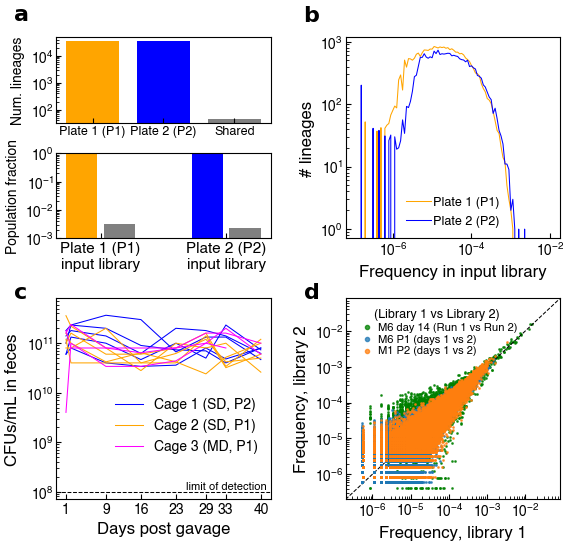

In [22]:
P1_index, P2_index = shared.library_array_map[('E1', 'P1')][0][1], shared.library_array_map[('E1', 'P2')][0][1]
P1_array, P1_depth = shared.vivo_array[P1_index], shared.vivo_depths[P1_index]
P2_array, P2_depth = shared.vivo_array[P2_index], shared.vivo_depths[P2_index]
P1_freqs = shared.calc_freqs(P1_array, P1_depth[0])
P2_freqs = shared.calc_freqs(P2_array, P2_depth[0])

P1_bool, P2_bool, ambiguous_bool = [shared.barcode_pool_assignments[pool][1] for pool in ['P1', 'P2', 'E1_shared']]
print(P1_bool.sum(), P2_bool.sum(), ambiguous_bool.sum())


## TO DO add day0 technical replicate array file
# day0_rep_array = []
# with open(f'{data_dir}/barcode_seq/all_barcode_reads_trimmed.csv', 'r') as f:
#     header = next(f)
#     for line in f:
#         rep_lst = [int(e) for e in line.split(',')[2:6]]
#         day0_rep_array.append(rep_lst)
# day0_rep_array = np.array(day0_rep_array).transpose()

# day0_freq_array = np.einsum('ij, i->ij', day0_rep_array, day0_rep_array.sum(axis=1)**-1.)
# P1_rep1_freqs, P1_rep2_freqs, P2_rep1_freqs, P2_rep2_freqs = day0_freq_array

with open(f'../data/other/expt1_cfus_per_mL.tsv', 'r') as f:
    next(f)
    header = next(f)
    days = [int(e) for e in header.strip('\n').split('\t')[1:]]

    cfus_mL_dict = {}
    for line in f:
        line_items = line.strip('\n').split('\t')
        mouse = int(line_items[0])

        cfus = [float(e) for e in line_items[1:]]

        cfus_mL_dict[mouse] = cfus
mouse_colors = {i:'blue' for i in range(1, 6)} | {i:'orange' for i in range(6, 11)} | {i:'fuchsia' for i in range(11, 14)}


### Plot technical replicates ~ Fig S1 ###
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

main_fig = plt.figure(figsize=(6.5, 6))
gs = plt.GridSpec(2, 2, figure=main_fig, wspace=0.35, hspace=0.3)

#####################################################
## panel A: barcode pool assignments to Plate 1, 2 ##
#####################################################

inner_grid = gs[0, 0].subgridspec(2, 1, hspace=0.35)
ax = main_fig.add_subplot(inner_grid[0])
ax2 = main_fig.add_subplot(inner_grid[1])
ax.text(-0.2, 1.2, '$\\bf{a}$', fontsize=16, transform=ax.transAxes)


x1_lst = [0, 1, 2]
y1_lst = [P1_bool.sum(), P2_bool.sum(), ambiguous_bool.sum()]
colors = ['Orange', 'Blue', 'Grey']
for x, y, color in zip(x1_lst, y1_lst, colors):
    ax.bar(x, y, facecolor=color, width=0.75)
ax.set_xticks([0, 1, 2])
ax.set_yscale('log')
# ax.set_ylim(ax.get_ylim()[0], 31000)
# ax.set_yticks([0, 10000, 20000, 30000])
# ax.set_yticklabels([0, '$10^4$', '$2 \cdot 10^4$', '$3 \cdot 10^4$'], fontsize=10)
ax.set_xticklabels(['Plate 1 (P1)', 'Plate 2 (P2)', 'Shared'], fontsize=9)
ax.set_ylabel('Num. lineages', fontsize=10)

x2_lst = [-0.15, 0.15, 0.85, 1.15]
y2_lst = [P1_freqs[P1_bool].sum(), P1_freqs[ambiguous_bool].sum(),
          P2_freqs[P2_bool].sum(), P2_freqs[ambiguous_bool].sum()]
colors = ['Orange', 'Grey', 'Blue', 'Grey']
hatches = [None, None, None, None]
for x, y, color, hatch in zip(x2_lst, y2_lst, colors, hatches):
    ax2.bar(x, y, facecolor=color, width=0.25, hatch=hatch)
ax2.set_yscale('log'); ax2.set_ylim(1e-3, 2)
ax2.set_ylim(0, 1.05)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Plate 1 (P1)\ninput library', 'Plate 2 (P2)\ninput library'], fontsize=11)
ax2.set_ylabel('Population fraction', fontsize=10)



#####################################################
## panel B: sequencing replicability ###
#####################################################

ax = main_fig.add_subplot(gs[0, 1])
ax.text(-0.2, 1.08, '$\\bf{b}$', fontsize=16, transform=ax.transAxes)


# ax.scatter(P1_rep1_freqs, P1_rep2_freqs, s=1, color='orange', rasterized=True, label="Plate 1 (P1)")
# ax.scatter(P2_rep1_freqs, P2_rep2_freqs, s=1, color='blue', rasterized=True, alpha=0.5, label="Plate 2 (P2)")
P1_density, bins = np.histogram( P1_freqs, bins=np.logspace(-7, -2, 101) )
ax.plot(bins[1:], P1_density, color='orange', alpha=1, label='Plate 1 (P1)')
P2_density, bins = np.histogram( P2_freqs, bins=np.logspace(-7, -2, 101) )
ax.plot(bins[1:], P2_density, color='blue', alpha=1, label='Plate 2 (P2)')

ax.legend(frameon=False, fontsize=9, markerscale=4, handletextpad=0.1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency in input library', fontsize=12)
# ax.set_ylabel('Rep 2 frequency', fontsize=12)
ax.set_ylabel('# lineages', fontsize=12)
# util.plot_diagonal(ax)

#####################################################
## panel D: within mouse day-to-day reproducibility ##
#####################################################
ax = main_fig.add_subplot(gs[1, 1])
ax.text(-0.2, 1.0, '$\\bf{d}$', fontsize=16, transform=ax.transAxes)
expt = 'E1'


# ('E1', 1, 3) [('vivo', 27), ('reseq', 0)]
rep2, rep1= shared.library_array_map[(expt, 6, 14)]
rep1_arr = shared.barcode_arrays[rep1[0]][0][rep1[1]]
rep1_depths = shared.barcode_arrays[rep1[0]][1][rep1[1]]
rep2_arr = shared.barcode_arrays[rep2[0]][0][rep2[1]]
rep2_depths = shared.barcode_arrays[rep2[0]][1][rep2[1]]

f1 = shared.calc_freqs(rep1_arr, rep1_depths[0])
f2 = shared.calc_freqs(rep2_arr, rep2_depths[0])
ax.scatter(f1, f2, s=1, rasterized=True, color='green', label=f'M{6} day 14 (Run 1 vs Run 2)', zorder=0, alpha=0.75)



for z, (mouse, color) in enumerate(zip([6, 1], ['blue', 'orange'])):
    rep1 = shared.library_array_map[(expt, mouse, 1)][0]
    rep2 = shared.library_array_map[(expt, mouse, 2)][0]

    rep1_arr = shared.barcode_arrays[rep1[0]][0][rep1[1]]
    rep1_depths = shared.barcode_arrays[rep1[0]][1][rep1[1]]
    rep2_arr = shared.barcode_arrays[rep2[0]][0][rep2[1]]
    rep2_depths = shared.barcode_arrays[rep2[0]][1][rep2[1]]

    f1 = shared.calc_freqs(rep1_arr, rep1_depths[0])
    f2 = shared.calc_freqs(rep2_arr, rep2_depths[0])
    ax.scatter(f1, f2, s=1, rasterized=True, label=f'M{mouse} P{z+1} (days 1 vs 2)', alpha=0.75)
    # day1_row = shared.vivo_row_ids[(expt, rep_mouse, 1)]
    # day2_row = shared.vivo_row_ids[(expt, rep_mouse, 2)]
    # f1 = shared.freq_array[day1_row]
    # f2 = shared.freq_array[day2_row]



ax.set_xlim(2*10**-7,8*10**-2)
ax.set_ylim(2*10**-7,8*10**-2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency, library 1', fontsize=12)
ax.set_ylabel('Frequency, library 2', fontsize=12)
util.plot_diagonal(ax)
ax.legend(title='(Library 1 vs Library 2)', title_fontsize=9, loc=2, frameon=False, fontsize=8, markerscale=3, handletextpad=0.05, labelspacing=0.15)

#####################################################
## panel C: CFUs/mL over time ##
#####################################################
ax = main_fig.add_subplot(gs[1, 0])
ax.text(-0.2, 1.0, '$\\bf{c}$', fontsize=16, transform=ax.transAxes)

for mouse in cfus_mL_dict:
    ax.plot(days, cfus_mL_dict[mouse], color=mouse_colors[mouse])

legend_markers = [plt.Line2D([0,0],[0,0],color=color) for color in ['blue', 'orange', 'fuchsia']]
ax.legend(legend_markers, ['Cage 1 (SD, P2)', 'Cage 2 (SD, P1)', 'Cage 3 (MD, P1)'], loc=(0.25, 0.2), fontsize=10, frameon=False)

ax.set_ylim(0.7*10**8, 0.8*10**12)
ax.axhline(10**8, linestyle='dashed', color='black')
ax.text(0.98, 0.04, f'limit of detection', transform=ax.transAxes, ha='right', va='bottom')

ax.set_xticks([days[0]] + days[2:])
ax.set_yscale('log')

ax.set_xlabel("Days post gavage",fontsize=12)
ax.set_ylabel("CFUs/mL in feces", fontsize=12)

plt.rcParams['svg.fonttype'] = 'none'
main_fig.savefig(f'../figures/sfig1_tech_reproducibility.pdf', bbox_inches='tight', transparent=True, dpi=300)
main_fig.savefig(f'../figures/sfig1_tech_reproducibility.svg', bbox_inches='tight', transparent=True, dpi=300)


In [23]:
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    if ndp == -1: # include only order of magnitude
        return r'10^{{{e:d}}}'.format(e=int(e))
    else:
        return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))


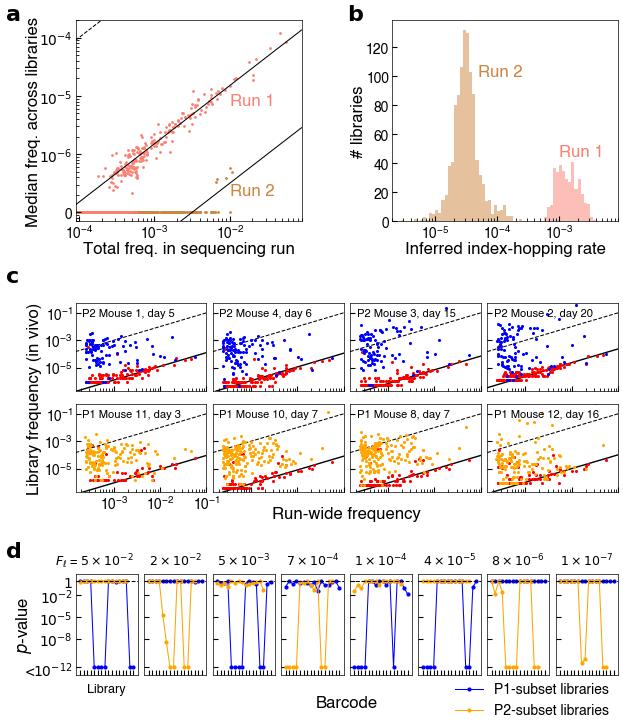

In [24]:
## index-hopping figure
figure = plt.figure(figsize=(7, 8.5))

gs = plt.GridSpec(3, 2, figure=figure, wspace=0.35, hspace=0.5, height_ratios=[1.6,1.5,0.8])
global_ax = figure.add_subplot(gs[:, :])
global_ax.text(-.13, 1, '$\\bf{a}$', fontsize=16, transform=global_ax.transAxes)
global_ax.text(0.5, 1, '$\\bf{b}$', fontsize=16, transform=global_ax.transAxes)
global_ax.text(-.13, 0.6, '$\\bf{c}$', fontsize=16, transform=global_ax.transAxes)
global_ax.text(-.13, 0.18, '$\\bf{d}$', fontsize=16, transform=global_ax.transAxes)
util.turn_off_ax(global_ax)

# summary ax
summary_gs = gs[0, :].subgridspec(1, 2, wspace=0.4, hspace=0.15)
median_ax = figure.add_subplot(summary_gs[0])
for seqrun_array, seqrun_depths, rescale, color in [(og_seq_array, og_seq_depths,10**-4.5, 'peru'), 
                                             (reseq_array, reseq_depths,  1.5*10**(-3), 'salmon')]:
    seqrun_bc_tot_freqs = seqrun_array.sum(axis=0) / seqrun_depths[:, 0].sum()
    sorting = np.argsort(seqrun_bc_tot_freqs)[::-1]
    lib_freqs = np.einsum('ij,i->ij', seqrun_array, seqrun_depths[:, 0]**-1.)
    median_freqs = np.percentile(lib_freqs, 50, axis=0)[sorting]
    median_freqs[median_freqs == 0] = 1e-7
    median_ax.scatter(seqrun_bc_tot_freqs[sorting[:1000]], median_freqs[:1000], s=1, color=color)
    median_ax.axline( (10**-3, rescale*10**-3), (10**-2, rescale*10**-2), color='black')

util.plot_diagonal(median_ax)
median_ax.set_yscale('log')
median_ax.set_xscale('log')
median_ax.set_xlim(9*10**-5, 9*10**-2)
median_ax.set_ylim(7*10**-8, 2*10**-4)
median_ax.set_yticks([10**-7, 10**-6, 10**-5, 10**-4])
median_ax.set_yticklabels([r'0', r'$10^{-6}$', r'$10^{-5}$', r'$10^{-4}$'])
median_ax.set_ylabel('Median freq. across libraries', fontsize=12, labelpad=-1)
median_ax.set_xlabel('Total freq. in sequencing run', fontsize=12, labelpad=0)
median_ax.text(10**-2, 7*10**-6, 'Run 1', color='salmon', fontsize=12)
median_ax.text(10**-2, 2*10**-7, 'Run 2', color='peru', fontsize=12)
for spine in median_ax.spines.values():
    spine.set_linewidth(0.5)



lib_hopping_ax = figure.add_subplot(summary_gs[1])
og_seq_hopping = np.array(list(barcode_hopping_rates['vivo']) + list(barcode_hopping_rates['vitro']))
# density, bins = np.histogram(og_seq_hopping[og_seq_depths[:,0] > 1e4], bins=np.logspace(-7, 0, 141))
lib_hopping_ax.hist(og_seq_hopping[og_seq_depths[:,0] > 1e4], bins=np.logspace(-7, 0, 141), alpha=0.5, color='peru')
lib_hopping_ax.text(5*10**-5, 100, 'Run 2', color='peru', fontsize=12)
# density, bins = np.histogram(barcode_hopping_rates['reseq'][reseq_depths[:,0] > 1e4], bins=np.logspace(-7, 0, 141))
lib_hopping_ax.hist(barcode_hopping_rates['reseq'][reseq_depths[:,0] > 1e4], bins=np.logspace(-7, 0, 141), alpha=0.5, color='salmon')
lib_hopping_ax.text(10**-3, 45, 'Run 1', color='salmon', fontsize=12)
lib_hopping_ax.set_xscale('log')
lib_hopping_ax.set_xlim(2*10**-6, 9*10**-3)
lib_hopping_ax.set_ylabel('# libraries', fontsize=12, labelpad=0)
lib_hopping_ax.set_xlabel('Inferred index-hopping rate', fontsize=12, labelpad=0)
for spine in lib_hopping_ax.spines.values():
    spine.set_linewidth(0.5)




## barcode ax
barcode_gs = gs[2, :].subgridspec(1, 8, wspace=0.1, hspace=0.15)
outer_ax = figure.add_subplot(barcode_gs[:, :])
# outer_ax.set_xlabel('Sequencing replicate                                              ', fontsize=12, labelpad=10)
outer_ax.set_xlabel('Barcode', fontsize=12, labelpad=15)
outer_ax.set_ylabel(r'$p$-value', fontsize=12, labelpad=30)
util.turn_off_ax(outer_ax)


example_barcodes = np.arange(0, 8)
# example_barcodes = []
example_barcodes = np.logspace(0, np.log10(60000), 8, dtype=int)
for z, bc_index in enumerate(example_barcodes):
    ax = figure.add_subplot(barcode_gs[z])

    bc_tot_freq = unsorted_reseq_freqs[sorting][bc_index]
    P1_pvals = P1_uncombined_sorted[:, bc_index]
    P2_pvals = P2_uncombined_sorted[:, bc_index]
    
    ax.plot( P1_pvals, marker='o', label='P1-subset libraries', markersize=2, lw=0.75, color='blue')
    ax.plot( P2_pvals, marker='o', label='P2-subset libraries', markersize=2, lw=0.75, color='orange')
    ax.set_yscale('log')
    ax.set_ylim( 10**-13, 10)
    ax.set_yticks( [10**-12, 10**-8, 10**-5, 10**-2, 1])
    ax.set_xlim(-1.25, 16.25)
    ax.set_yticklabels([r'<$10^{{-12}}$',r'$10^{{-8}}$', r'$10^{{-5}}$', r'$10^{{-2}}$', r'$1$'])
    # ax.set_title(f'Barcode {bc_index}: f_tot = {bc_tot_freq:.2e}', fontsize=10)
    if z == 0:
        # situate legend at bottom, below plot
        ax.set_title(r'$F_\ell$ = '+ f'${as_si(bc_tot_freq, 0)}$        ', fontsize=9)
        ax.set_xlabel('Library', fontsize=9)
    if z != 0:
        ax.set_yticklabels([])
        ax.set_title(f'${as_si(bc_tot_freq, 0)}$', fontsize=9)
    if z == 7:
        ax.legend(loc='lower right', bbox_to_anchor=(1.05, -0.55),  fontsize=10, frameon=False)

    # ax.set_xticks([])
    ax.set_xticks(range(0, 16))
    ax.set_xticklabels([])
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
    ax.axhline(1, color='black', linestyle='dashed')
    

### example libraries
# fig, axs = plt.subplots(2,4, figsize=(8,4.5), gridspec_kw={'wspace':0.05, 'hspace':0.15})
lib_gs = gs[1, :].subgridspec(2, 4, wspace=0.05, hspace=0.15)
outer_ax = figure.add_subplot(lib_gs[:, :])
outer_ax.set_xlabel('Run-wide frequency', fontsize=12, labelpad=10)
outer_ax.set_ylabel('Library frequency (in vivo)', fontsize=12, labelpad=24)
util.turn_off_ax(outer_ax)

example_libraries = rnd.choice(range(len(reseq_array)), 8, replace=False)
# example_libraries = [22,34, 71, 122, 9, 254,281,296] # representative libraries 
example_libraries = [22,34, 71, 122, 9, 49,47, 97] # representative libraries 

for z, arr_index in enumerate(example_libraries):
    ax = figure.add_subplot(lib_gs[z//4, z%4])


    (expt, pop, day) = col_id_map['reseq'][arr_index]
    est_hopping_rate = barcode_hopping_rates['reseq'][arr_index]
    lib_hopping_data = hopping_inference_data[('reseq', arr_index)]

    # if ('reseq', arr_index) in 
    if expt == 'E1' and type(pop) == int and pop < 6:
        barcode_indices = barcode_pool_assignments['P2'][0]
        inoc = 'P2'
    elif expt == 'E1' and type(pop) == int and pop >= 6:
        barcode_indices = barcode_pool_assignments['P1'][0]
        inoc = 'P1'
    elif expt == 'E2' and type(pop) == int and pop in [1,6,11]:
        barcode_indices = barcode_pool_assignments['S1'][0]
        inoc = "S1"
    elif expt == 'E2' and type(pop) == int and pop in [2,7,12]:
        barcode_indices = barcode_pool_assignments['S2'][0]
        inoc = "S2"
    else:
        continue


    large_indices = lib_hopping_data['included_indices']
    valid_bool = lib_hopping_data['valid_bool']

    run_freqs = lib_hopping_data['run_freqs']
    lib_freqs = lib_hopping_data['lib_freqs']

    in_inoculum = [i in barcode_indices for  i in large_indices]
    not_in_inoculum = [i not in barcode_indices for i in large_indices]

    if z < 4:
        color = 'blue'
    else:
        color = 'orange'
    ax.scatter( run_freqs[not_in_inoculum], lib_freqs[not_in_inoculum], s=1.5, color='red' )
    ax.scatter( run_freqs[in_inoculum], lib_freqs[in_inoculum], s=1.5, color=color)
    ax.axline( (10**-3, 10**-3 * est_hopping_rate), (10**-2, 10**-2 * est_hopping_rate), color='black', lw=1, zorder=0)
    util.plot_diagonal( ax )
    # ax.set_title(f'{arr_index}, {expt}, {pop}, {day}')
    ax.text(0.05, 0.85, f'{inoc} Mouse {pop}, day {day}', transform=ax.transAxes, fontsize=8)
    ax.set_yscale('log')
    ax.set_xscale('log')
    if z not in [0, 4]:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    if z not in [4]:
        ax.set_xticklabels([])
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

    ax.set_xlim( 1.5*10**-4, 10**-1)
    ax.set_ylim( 2*10**-7, 0.5)

plt.rcParams['svg.fonttype'] = 'none'
figure.savefig(f'../figures/sfig_index_hopping.pdf', bbox_inches='tight', transparent=True, dpi=300)
figure.savefig(f'../figures/sfig_index_hopping.svg', bbox_inches='tight', transparent=True, dpi=300)